In [266]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_score

from xverse.transformer import WOE

In [142]:
paths = [
    ("./Data/Dataset/bus", "bus"),
    ("./Data/Dataset/car", "car"),
    ("./Data/Dataset/pedestrian", "pedestrian"),
    ("./Data/Dataset/static", "static"),
    ("./Data/Dataset/train", "train")
]

filenames = []
for path, label in paths:
    filenames.extend([(filename, label) for filename in glob.glob(os.path.join(path, "*.csv"))])

Lis = []
for filename, label in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['path'] = label
    Lis.append(df)

LTE_data = pd.concat(Lis, axis=0, ignore_index=True)

In [143]:
LTE_data = LTE_data[LTE_data['NetworkMode']=='LTE']

In [144]:
LTE_data = LTE_data.drop(['Timestamp','CellID','Operatorname','NetworkMode','State','path'], axis=1)

In [145]:
#Remove rows with non-existant values
for column in LTE_data:
    LTE_data = LTE_data[LTE_data[column] != '-']

In [146]:
# Change object columns to numeric
object_columns = LTE_data.select_dtypes('object')
for column in object_columns:
    LTE_data[column] = pd.to_numeric(LTE_data[column])

In [147]:
# Change SNR to binary class
LTE_data['SNR'] = (LTE_data['SNR'] > 0).astype(int)

In [148]:
LTE_data.corr()['SNR'].sort_values(ascending=False)

SNR                     1.000000
RSRQ                    0.628235
CQI                     0.435776
DL_bitrate              0.417344
UL_bitrate              0.400552
RSRP                    0.260780
RSSI                    0.254445
NRxRSRQ                 0.193194
NRxRSRP                 0.160858
Speed                   0.108441
ServingCell_Lat         0.095299
Latitude                0.088588
ServingCell_Distance    0.011619
ServingCell_Lon        -0.004435
Longitude              -0.015127
Name: SNR, dtype: float64

In [337]:
LTE_data

,Longitude,Latitude,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance
38,-8.501291,51.893462,1,-110,-15,0,7,-94,626,12,-118.0,-20.0,-8.491719,51.893905,658.68
39,-8.501291,51.893462,1,-110,-15,0,7,-94,693,13,-118.0,-20.0,-8.491719,51.893905,658.68
47,-8.502645,51.893069,16,-115,-15,0,6,-94,78,3,-118.0,-18.0,-8.491719,51.893905,755.50
48,-8.502645,51.893069,16,-115,-15,0,6,-94,246,12,-118.0,-18.0,-8.491719,51.893905,755.50
49,-8.502645,51.893069,16,-111,-15,0,7,-94,123,6,-118.0,-20.0,-8.491719,51.893905,755.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174512,-8.490956,51.934883,74,-107,-13,1,7,-90,19728,361,-111.0,-16.0,-8.489758,51.928426,722.67
174513,-8.490956,51.934883,74,-106,-13,1,9,-88,28306,507,-109.0,-15.0,-8.489758,51.928426,722.67
174514,-8.490956,51.934883,74,-106,-13,1,9,-91,30700,547,-109.0,-15.0,-8.489758,51.928426,722.67
174517,-8.490956,51.934883,74,-102,-12,1,11,-85,38226,677,-109.0,-18.0,-8.489758,51.928426,722.67


In [159]:
LTE_data.corr()

,Longitude,Latitude,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance
Longitude,1.000000,0.464063,0.087420,-0.061757,0.074684,-0.015127,-0.120328,-0.073305,-0.113409,-0.102231,-0.027427,0.063466,0.737264,0.421533,-0.013050
Latitude,0.464063,1.000000,0.447006,-0.126857,0.183898,0.088588,-0.185479,-0.118529,-0.097043,-0.112455,-0.079111,0.150524,0.377033,0.936093,0.062712
Speed,0.087420,0.447006,1.000000,-0.174742,0.189092,0.108441,-0.101021,-0.183116,-0.036960,-0.005275,-0.104653,0.174693,0.046327,0.417506,0.085388
RSRP,-0.061757,-0.126857,-0.174742,1.000000,0.355649,0.260780,0.364966,0.955975,0.342202,0.314711,0.844031,0.115536,-0.060446,-0.122221,-0.009675
RSRQ,0.074684,0.183898,0.189092,0.355649,1.000000,0.628235,0.405325,0.310114,0.386972,0.376153,0.232626,0.317862,0.053056,0.175585,0.035717
SNR,-0.015127,0.088588,0.108441,0.260780,0.628235,1.000000,0.435776,0.254445,0.417344,0.400552,0.160858,0.193194,-0.004435,0.095299,0.011619
CQI,-0.120328,-0.185479,-0.101021,0.364966,0.405325,0.435776,1.000000,0.392934,0.495474,0.475472,0.244604,0.126383,-0.119356,-0.183453,0.002069
RSSI,-0.073305,-0.118529,-0.183116,0.955975,0.310114,0.254445,0.392934,1.000000,0.332673,0.300304,0.814868,0.091670,-0.057879,-0.115173,-0.024117
DL_bitrate,-0.113409,-0.097043,-0.036960,0.342202,0.386972,0.417344,0.495474,0.332673,1.000000,0.919676,0.271320,0.259175,-0.090382,-0.096052,-0.000052
UL_bitrate,-0.102231,-0.112455,-0.005275,0.314711,0.376153,0.400552,0.475472,0.300304,0.919676,1.000000,0.249702,0.235694,-0.079740,-0.111253,-0.005631


# WORKFLOW AND TESTBED VALIDATION

In [150]:
X = LTE_data.drop('SNR', axis=1)
y = LTE_data.SNR

In [151]:
kbd = KBinsDiscretizer(n_bins=3)

In [152]:
X_bin = kbd.fit_transform(X)

In [153]:
feature_names = kbd.get_feature_names_out()

## Information Value

In [154]:
woe = WOE()
woe.fit(X, y)

WOE(mono_custom_binning={'CQI': array([ 1.,  6.,  8., 15.]),
                         'DL_bitrate': array([     0.,   3355.,  12839., 133906.]),
                         'Latitude': array([51.871394, 51.893853, 51.900334, 53.346003]),
                         'Longitude': array([-9.578864, -8.49995 , -8.479341, -6.297736]),
                         'NRxRSRP': array([-138., -106.,  -98.,    0.]),
                         'NRxRSRQ': array([-225.,  -17.,  -15.,   -2.]),
                         'RSRP': array([-138., -105.,  -96.,  -27.]),
                         'RSRQ': array([-...
              'Speed': {Interval(-0.001, 1.0, closed='right'): -0.18068722922871122,
                        Interval(1.0, 22.0, closed='right'): -0.050746811080046667,
                        Interval(22.0, 162.0, closed='right'): 0.2389575156471268},
              'UL_bitrate': {Interval(-0.001, 71.0, closed='right'): -0.8761168581363892,
                             Interval(71.0, 230.0, closed='right'): -0.25796894824739774,
                             Interval(230.0, 1975.0, closed='right'): 1.3865471774892013}})

In [156]:
woe.iv_df

,Variable_Name,Information_Value
7,RSRQ,2.173743
0,CQI,1.020042
1,DL_bitrate,0.898327
13,UL_bitrate,0.795514
10,ServingCell_Lat,0.262379
6,RSRP,0.238163
8,RSSI,0.228593
5,NRxRSRQ,0.226659
2,Latitude,0.136674
4,NRxRSRP,0.097054


## Random Forest Classifier

In [62]:
rf = RandomForestClassifier()

In [63]:
rf.fit(X_bin, y)

RandomForestClassifier()

In [78]:
importances = rf.feature_importances_

In [79]:
aggregated_importances = []
for i in range(14):
    start_idx = i * 3
    end_idx = (i + 1) * 3
    feature_importances = importances[start_idx:end_idx]
    aggregated_importance = sum(feature_importances)
    aggregated_importances.append(aggregated_importance)

In [81]:
feature_importances = dict(zip(X.columns, aggregated_importances))

In [82]:
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

In [83]:
sorted_importances

[('RSRQ', 0.4124380389158808),
 ('CQI', 0.11020268457784173),
 ('DL_bitrate', 0.06134317031370724),
 ('UL_bitrate', 0.05244847543949249),
 ('NRxRSRQ', 0.0486655057618691),
 ('ServingCell_Lat', 0.04260235372757872),
 ('ServingCell_Distance', 0.041983705332478374),
 ('Speed', 0.04000467380455183),
 ('NRxRSRP', 0.03565827484418305),
 ('Latitude', 0.03198292942118844),
 ('RSRP', 0.031387510852332566),
 ('Longitude', 0.030888897974529414),
 ('RSSI', 0.03032065301652522),
 ('ServingCell_Lon', 0.030073126017840998)]

## ExtrTrees Classifier

In [30]:
etc = ExtraTreesClassifier()

In [31]:
etc.fit(X_bin, y)

ExtraTreesClassifier()

In [32]:
importances = etc.feature_importances_

In [33]:
aggregated_importances = []
for i in range(14):
    start_idx = i * 3
    end_idx = (i + 1) * 3
    feature_importances = importances[start_idx:end_idx]
    aggregated_importance = sum(feature_importances)
    aggregated_importances.append(aggregated_importance)

In [34]:
feature_importances = dict(zip(X.columns, aggregated_importances))

In [35]:
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

In [36]:
sorted_importances

[('RSRQ', 0.407126071396297),
 ('CQI', 0.09588379830260443),
 ('DL_bitrate', 0.07109674959349996),
 ('UL_bitrate', 0.06357905398803171),
 ('NRxRSRQ', 0.0472492550653123),
 ('ServingCell_Lat', 0.0434599132292315),
 ('ServingCell_Distance', 0.040834228962253964),
 ('Speed', 0.039388989808293785),
 ('NRxRSRP', 0.035665305442145766),
 ('Latitude', 0.032893660445980216),
 ('RSRP', 0.031481752990553606),
 ('RSSI', 0.031187656465445437),
 ('Longitude', 0.030956611175880628),
 ('ServingCell_Lon', 0.029196953134469565)]

## Chi Square

In [52]:
chi2, p_values = chi2(X_bin, y)

In [53]:
chi2

array([1.61393697e-01, 3.52387429e+02, 3.69472057e+02, 6.58338622e+02,
       5.71289927e+01, 1.08366494e+03, 1.21432847e+02, 3.05071706e+01,
       2.65830991e+02, 1.16593061e+03, 1.10754477e+02, 1.82265568e+03,
       1.58405929e+04, 2.52391368e+02, 1.16793785e+04, 5.84028546e+03,
       2.89032790e+02, 5.75444083e+03, 1.05758918e+03, 1.31242873e+02,
       1.76921531e+03, 3.60432168e+03, 4.53865097e+02, 6.61475766e+03,
       3.40371664e+03, 3.47474856e+02, 5.89381853e+03, 3.93902557e+02,
       7.44862022e+01, 7.18798212e+02, 2.47136326e+02, 6.61921283e+02,
       1.22729465e+03, 2.32838643e+02, 4.55525281e+01, 4.60174393e+02,
       1.17055035e+02, 1.24232596e+03, 2.21672005e+03, 5.76689966e+01,
       7.46977945e+01, 1.08389849e+00])

In [58]:
aggregated_importances = []
for i in range(14):
    start_idx = i * 3
    end_idx = (i + 1) * 3
    feature_importances = chi2[start_idx:end_idx]
    aggregated_importance = sum(feature_importances)
    aggregated_importances.append(aggregated_importance)

In [59]:
feature_importances = dict(zip(X.columns, aggregated_importances))

In [60]:
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

In [61]:
sorted_importances

[('RSRQ', 27772.36273742924),
 ('CQI', 11883.759078101695),
 ('DL_bitrate', 10672.944441318672),
 ('UL_bitrate', 9645.010027324846),
 ('ServingCell_Lat', 3576.101049864452),
 ('RSRP', 3099.3407731647994),
 ('RSSI', 2958.0473655495034),
 ('NRxRSRQ', 2136.352253923779),
 ('Latitude', 1799.1325590909892),
 ('NRxRSRP', 1187.1869710845845),
 ('ServingCell_Lon', 738.565564387803),
 ('Longitude', 722.020879705191),
 ('Speed', 417.77100775047273),
 ('ServingCell_Distance', 133.45068968371893)]

## Variance Inflation Factor

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [73]:
pd.Series([variance_inflation_factor(LTE_data.values, i) 
               for i in range(LTE_data.shape[1])], 
              index=LTE_data.columns).sort_values(ascending=False)

ServingCell_Lat         1.365329e+06
Latitude                1.361166e+06
Longitude               9.414867e+03
ServingCell_Lon         7.640630e+03
RSRP                    1.053337e+03
RSSI                    7.363153e+02
NRxRSRP                 3.326392e+02
RSRQ                    6.308721e+01
NRxRSRQ                 3.009360e+01
CQI                     1.435741e+01
UL_bitrate              1.319430e+01
DL_bitrate              1.241206e+01
ServingCell_Distance    4.872704e+00
SNR                     4.099198e+00
Speed                   1.761435e+00
dtype: float64

# ROC Curve Analysis

In [172]:
X = LTE_data[['RSRQ', 'CQI', 'DL_bitrate', 'UL_bitrate']]
y = LTE_data['SNR']

In [173]:
kbd = KBinsDiscretizer(n_bins=3)
X_bin = kbd.fit_transform(X)

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X_bin, y, test_size=0.4)

## Random Forest Classifier

In [260]:
rf = RandomForestClassifier().fit(X_train, y_train)

In [261]:
preds = rf.predict_proba(X_train)[:, 1]

In [262]:
fpr, tpr, thresholds = roc_curve(y_train, preds, pos_label=1)

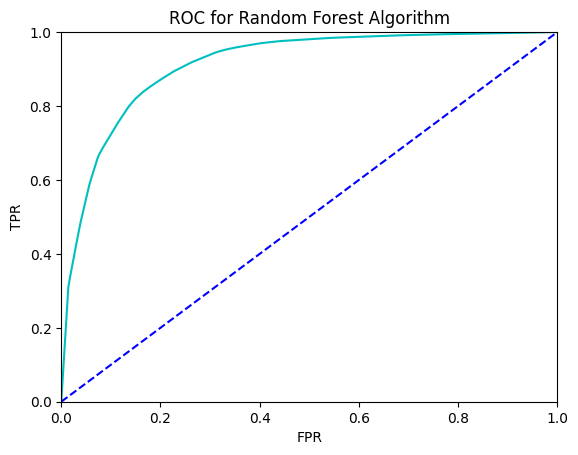

In [263]:
plt.title('ROC for Random Forest Algorithm')
plt.plot(fpr, tpr, 'c')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

## Logistic Regression

In [253]:
lr = LogisticRegression().fit(X_train, y_train)

In [254]:
preds = lr.predict_proba(X_train)[:, 1]

In [255]:
fpr, tpr, thresholds = roc_curve(y_train, preds, pos_label=1)

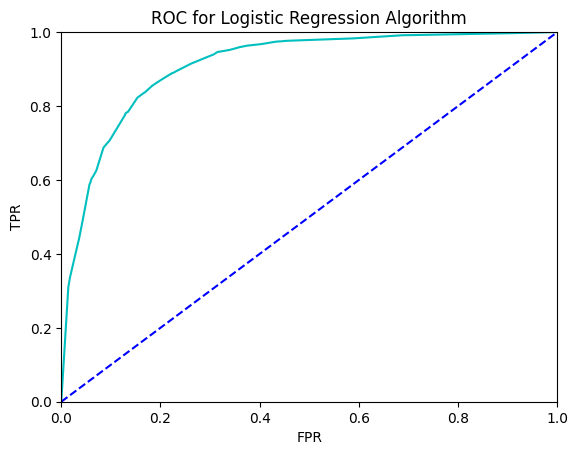

In [256]:
plt.title('ROC for Logistic Regression Algorithm')
plt.plot(fpr, tpr, 'c')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

## Gradient Boosting 

In [226]:
gbc = GradientBoostingClassifier().fit(X_train, y_train)

In [233]:
preds = gbc.predict_proba(X_train)[:, 1]

In [234]:
fpr, tpr, thresholds = roc_curve(y_train, preds, pos_label=1)

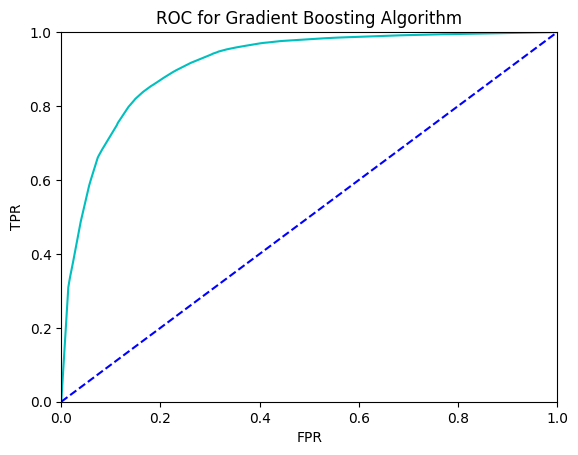

In [235]:
plt.title('ROC for Gradient Boosting Algorithm')
plt.plot(fpr, tpr, 'c')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

# Precision and AUC

## Random Forest

In [312]:
rf = RandomForestClassifier().fit(X_train, y_train)

In [313]:
preds = rf.predict(X_train)

In [314]:
auc = roc_auc_score(y_train, preds)

In [315]:
p = precision_score(y_train, preds)

In [316]:
rf_p_trd = "%.2f" % (p * 100) + " %"

In [317]:
rf_auc_trd = "%.2f" % (auc * 100) + " %"

In [318]:
preds = rf.predict(X_test)
auc = roc_auc_score(y_test, preds)
p = precision_score(y_test, preds)

In [319]:
rf_p_ted = "%.2f" % (p * 100) + " %"
rf_auc_ted = "%.2f" % (auc * 100) + " %"

## Logistic Regression

In [325]:
lr = LogisticRegression().fit(X_train, y_train)

In [326]:
preds = lr.predict(X_train)
auc = roc_auc_score(y_train, preds)
p = precision_score(y_train, preds)

In [327]:
lr_p_trd = "%.2f" % (p * 100) + " %"
lr_auc_trd = "%.2f" % (auc * 100) + " %"

In [328]:
preds = lr.predict(X_test)
auc = roc_auc_score(y_test, preds)
p = precision_score(y_test, preds)

In [329]:
lr_p_ted = "%.2f" % (p * 100) + " %"
lr_auc_ted = "%.2f" % (auc * 100) + " %"

## Gradient Boosting

In [330]:
gb = GradientBoostingClassifier().fit(X_train, y_train)

In [331]:
preds = gb.predict(X_train)
auc = roc_auc_score(y_train, preds)
p = precision_score(y_train, preds)

In [332]:
gb_p_trd = "%.2f" % (p * 100) + " %"
gb_auc_trd = "%.2f" % (auc * 100) + " %"

In [333]:
preds = gb.predict(X_test)
auc = roc_auc_score(y_test, preds)
p = precision_score(y_test, preds)

In [334]:
gb_p_ted = "%.2f" % (p * 100) + " %"
gb_auc_ted = "%.2f" % (auc * 100) + " %"

## P-AUC Table

In [335]:
table = pd.DataFrame({'Algorithm':['RF','LR','GB'], 'P, TRD':[rf_p_trd, lr_p_trd, gb_p_trd], 'P, TED':[rf_p_ted, lr_p_ted, gb_p_ted],
                      'AUC, TRD':[rf_auc_trd, lr_auc_trd, gb_auc_trd], 'AUC, TED':[rf_auc_ted, lr_auc_ted, gb_auc_ted]})

In [336]:
table

,Algorithm,"P, TRD","P, TED","AUC, TRD","AUC, TED"
0,RF,82.92 %,82.54 %,83.34 %,82.95 %
1,LR,83.10 %,82.80 %,83.29 %,83.01 %
2,GB,82.87 %,82.50 %,83.30 %,82.94 %
